In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import torch.nn as nn
import torch.nn.functional as F

from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device, device.type)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

cuda cuda
Files already downloaded and verified
Files already downloaded and verified


In [3]:
%%bash
nvidia-smi

Sun Dec  8 15:19:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A1000 6GB Lap...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8              4W /   45W |     720MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
class BatchNormConv2d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super(BatchNormConv2d, self).__init__()
        self.gelu = nn.GELU()
        self.conv = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_ch)
        
    def forward(self, x):
        return self.gelu(self.bn(self.conv(x)))

In [5]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch, kernel_sizes=(1, 3, 1), stride=1):
        super(BottleneckBlock, self).__init__()
        #added padding based on kernel size to keep image resolution
        self.reduce = BatchNormConv2d(in_ch, mid_ch, kernel_size=kernel_sizes[0], stride=stride, padding=kernel_sizes[0] // 2)
        self.maintain = BatchNormConv2d(mid_ch, mid_ch, kernel_size=kernel_sizes[1], stride=1, padding=kernel_sizes[1] // 2)
        self.expand = BatchNormConv2d(mid_ch, out_ch, kernel_size=kernel_sizes[2], stride=1, padding=kernel_sizes[2] // 2)
        
        self.residual = None
        if in_ch != out_ch:
            self.residual = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride)
    def forward(self, x):
        res = self.residual(x) if self.residual else x
        x = self.reduce(x)
        x = self.maintain(x)
        x = self.expand(x)
        return F.gelu(x + res)

In [6]:
class BottleneckModel(nn.Module):
    def __init__(self, in_ch=3, num_classes=10, bottleneck_configs=None):
        super(BottleneckModel, self).__init__()
        if bottleneck_configs is None:
            bottleneck_configs = [
                (3, 16, 32, (1, 3, 1)),
                (32, 32, 32, (1, 3, 1)),
                (32, 64, 64, (1, 5, 1))
            ]

        #we have to use ModuleList here since a normal list wouldn't be able to be moved onto the GPU (or through 'dirty" explicit move of the list to the GPU)
        self.bottlenecks = nn.ModuleList([BottleneckBlock(*config) for config in bottleneck_configs])        
        self.pool = nn.MaxPool2d((2, 2))

        # define MLP layer with the correct input size (too lazy to calculate)
        self.mlp = nn.Linear(bottleneck_configs[-1][2]*4*4, num_classes)

    def forward(self, x):
        for block in self.bottlenecks:
            x = block(x)
            x = self.pool(x)
        
        x = torch.flatten(x, 1)
        x = self.mlp(x)
        
        return F.softmax(x, dim=1)

In [7]:
conv_model = BottleneckModel()
if device.type == "cuda":
    conv_model = conv_model.to('cuda')
learning_rate = 0.001
BATCH_SIZE = 128
epochs = 15

train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, pin_memory=True)

#move dataset loader to gpu for each batch all at once to avoid moving memory during training
#train_loader = move_dataloader_to_device(train_loader, device)
#test_loader = move_dataloader_to_device(test_loader, device)

opt = torch.optim.Adam(conv_model.parameters(), lr=learning_rate)
print(conv_model, opt, device)

BottleneckModel(
  (bottlenecks): ModuleList(
    (0): BottleneckBlock(
      (reduce): BatchNormConv2d(
        (gelu): GELU(approximate='none')
        (conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (maintain): BatchNormConv2d(
        (gelu): GELU(approximate='none')
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (expand): BatchNormConv2d(
        (gelu): GELU(approximate='none')
        (conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (residual): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): BottleneckBlock(
      (reduce): BatchNormConv2d(
        (gelu): GELU(approximate='none')
        (con

In [13]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    avg_loss = fit_one_cycle(conv_model, train_loader, opt, epoch, writer, device, flatten=False)
    acc = prediction_accuracy(conv_model, test_loader, device, flatten=False)
    print(f"Accuracy: {acc * 100}% ({acc})\nLoss: {avg_loss}")

Epoch 1



raining: 100%|███████████████████████████████| 391/391 [00:09<00:00, 42.03it/s]

Correct: 5735, Total: 10000, Accuracy: 0.57
Accuracy: 57.35% (0.5735)
Loss: 1.874080312879462
Epoch 2



raining: 100%|███████████████████████████████| 391/391 [00:09<00:00, 43.39it/s]

Correct: 6190, Total: 10000, Accuracy: 0.62
Accuracy: 61.9% (0.619)
Loss: 1.8320206278248836
Epoch 3



raining: 100%|███████████████████████████████| 391/391 [00:08<00:00, 43.77it/s]

Correct: 6549, Total: 10000, Accuracy: 0.65
Accuracy: 65.49000000000001% (0.6549)
Loss: 1.7826260328292847
Epoch 4



raining: 100%|███████████████████████████████| 391/391 [00:09<00:00, 41.35it/s]

Correct: 6680, Total: 10000, Accuracy: 0.67
Accuracy: 66.8% (0.668)
Loss: 1.7729247055555646
Epoch 5



raining: 100%|███████████████████████████████| 391/391 [00:09<00:00, 41.93it/s]

Correct: 6811, Total: 10000, Accuracy: 0.68
Accuracy: 68.11% (0.6811)
Loss: 1.7453329939591258
Epoch 6



raining: 100%|███████████████████████████████| 391/391 [00:08<00:00, 46.01it/s]

Correct: 6794, Total: 10000, Accuracy: 0.68
Accuracy: 67.94% (0.6794)
Loss: 1.7350403007708097
Epoch 7



raining: 100%|███████████████████████████████| 391/391 [00:08<00:00, 43.63it/s]

Correct: 6930, Total: 10000, Accuracy: 0.69
Accuracy: 69.3% (0.693)
Loss: 1.7184977719658299
Epoch 8



raining: 100%|███████████████████████████████| 391/391 [00:08<00:00, 44.58it/s]

Correct: 6979, Total: 10000, Accuracy: 0.70
Accuracy: 69.78999999999999% (0.6979)
Loss: 1.7086453375063444
Epoch 9



raining: 100%|███████████████████████████████| 391/391 [00:09<00:00, 42.55it/s]

Correct: 7036, Total: 10000, Accuracy: 0.70
Accuracy: 70.36% (0.7036)
Loss: 1.6883668899536133
Epoch 10



raining: 100%|███████████████████████████████| 391/391 [00:08<00:00, 46.23it/s]

Correct: 7390, Total: 10000, Accuracy: 0.74
Accuracy: 73.9% (0.739)
Loss: 1.666273700563531
Epoch 11



raining: 100%|███████████████████████████████| 391/391 [00:08<00:00, 46.45it/s]

Correct: 7409, Total: 10000, Accuracy: 0.74
Accuracy: 74.09% (0.7409)
Loss: 1.646876059080425
Epoch 12



raining: 100%|███████████████████████████████| 391/391 [00:08<00:00, 46.86it/s]

Correct: 7445, Total: 10000, Accuracy: 0.74
Accuracy: 74.45% (0.7445)
Loss: 1.6176895530600297
Epoch 13



raining: 100%|███████████████████████████████| 391/391 [00:08<00:00, 46.75it/s]

Correct: 7461, Total: 10000, Accuracy: 0.75
Accuracy: 74.61% (0.7461)
Loss: 1.6056640399129767
Epoch 14



raining: 100%|███████████████████████████████| 391/391 [00:08<00:00, 46.83it/s]

Correct: 7420, Total: 10000, Accuracy: 0.74
Accuracy: 74.2% (0.742)
Loss: 1.6088451398046393
Epoch 15



raining: 100%|███████████████████████████████| 391/391 [00:08<00:00, 45.87it/s]

Correct: 7476, Total: 10000, Accuracy: 0.75
Accuracy: 74.76% (0.7476)
Loss: 1.587055243943867


In [ ]:
#validation_loop(conv_model, train_loader, epochs, writer, device, opt, timestamp, flatten=False)

In [16]:
#testing different configurations to find the best model
model_configs = [
    [(3, 16, 32, (1, 3, 1)), (32, 32, 32, (1, 3, 1)), (32, 64, 64, (1, 5, 1))],  # Default config
    [(3, 8, 16, (1, 3, 1)), (16, 16, 32, (1, 3, 1)), (32, 64, 64, (1, 3, 1))],   # Smaller bottlenecks
    [(3, 32, 64, (1, 5, 1)), (64, 128, 128, (1, 5, 1)), (128, 256, 256, (1, 3, 1))], # Larger bottlenecks
]
best_accuracy = 0
best_config = None
for idx, bottleneck_config in enumerate(model_configs):
    print(f"Training configuration {idx + 1}/{len(model_configs)}: {bottleneck_config}")
    conv_model = BottleneckModel(in_ch=3, num_classes=10, bottleneck_configs=bottleneck_config).to(device)
    if device.type == "cuda":
        conv_model = conv_model.to('cuda')
    opt = torch.optim.Adam(conv_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    BATCH_SIZE = 128

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/bottleneck_trainer_{}_{}'.format(idx, timestamp))

    acc = 0
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        avg_loss = fit_one_cycle(conv_model, train_loader, opt, epoch, writer, device, flatten=False)
        acc = prediction_accuracy(conv_model, test_loader, device, flatten=False)
        print(f"Accuracy: {acc * 100}% ({acc})\nLoss: {avg_loss}")
    # Evaluate the model
    conv_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = conv_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = correct / total
    print(f"Configuration {idx + 1}: Accuracy = {accuracy:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = bottleneck_config

print("\nBest Configuration:", best_config)
print("Best Accuracy:", best_accuracy)
    

Training configuration 1/3: [(3, 16, 32, (1, 3, 1)), (32, 32, 32, (1, 3, 1)), (32, 64, 64, (1, 5, 1))]
Epoch 1



raining: 100%|███████████████████████████████| 391/391 [00:08<00:00, 45.24it/s]

Correct: 5726, Total: 10000, Accuracy: 0.57
Accuracy: 57.26% (0.5726)
Loss: 1.9001778050472862
Epoch 2



raining: 100%|███████████████████████████████| 391/391 [00:09<00:00, 43.22it/s]

Correct: 6233, Total: 10000, Accuracy: 0.62
Accuracy: 62.33% (0.6233)
Loss: 1.8144160885559886
Epoch 3



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.85it/s]

Correct: 6765, Total: 10000, Accuracy: 0.68
Accuracy: 67.65% (0.6765)
Loss: 1.7679873014751233
Epoch 4



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:07<00:00, 50.08it/s]

Correct: 7084, Total: 10000, Accuracy: 0.71
Accuracy: 70.84% (0.7084)
Loss: 1.7404596931055973
Epoch 5



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:07<00:00, 50.70it/s]

Correct: 7239, Total: 10000, Accuracy: 0.72
Accuracy: 72.39% (0.7239)
Loss: 1.70355350720255
Epoch 6



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:08<00:00, 48.57it/s]

Correct: 7426, Total: 10000, Accuracy: 0.74
Accuracy: 74.26% (0.7426)
Loss: 1.6994012656964754
Epoch 7



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:07<00:00, 50.02it/s]

Correct: 7372, Total: 10000, Accuracy: 0.74
Accuracy: 73.72% (0.7372)
Loss: 1.6732944312848543
Epoch 8



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:07<00:00, 50.72it/s]

Correct: 7498, Total: 10000, Accuracy: 0.75
Accuracy: 74.98% (0.7498)
Loss: 1.6399724608973454
Epoch 9



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:07<00:00, 50.63it/s]

Correct: 7540, Total: 10000, Accuracy: 0.75
Accuracy: 75.4% (0.754)
Loss: 1.6301152517921047
Epoch 10



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.40it/s]

Correct: 7637, Total: 10000, Accuracy: 0.76
Accuracy: 76.37% (0.7637)
Loss: 1.6257163097983913
Epoch 11



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:08<00:00, 47.56it/s]

Correct: 7611, Total: 10000, Accuracy: 0.76
Accuracy: 76.11% (0.7611)
Loss: 1.621430610355578
Epoch 12



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:08<00:00, 46.56it/s]

Correct: 7611, Total: 10000, Accuracy: 0.76
Accuracy: 76.11% (0.7611)
Loss: 1.5976847159235101
Epoch 13



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:08<00:00, 47.36it/s]

Correct: 7633, Total: 10000, Accuracy: 0.76
Accuracy: 76.33% (0.7633)
Loss: 1.596221735602931
Epoch 14



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:08<00:00, 47.00it/s]

Correct: 7661, Total: 10000, Accuracy: 0.77
Accuracy: 76.61% (0.7661)
Loss: 1.588272119823255
Epoch 15



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.87it/s]

Correct: 7677, Total: 10000, Accuracy: 0.77
Accuracy: 76.77000000000001% (0.7677)
Loss: 1.5807018029062372
Configuration 1: Accuracy = 0.7669
Training configuration 2/3: [(3, 8, 16, (1, 3, 1)), (16, 16, 32, (1, 3, 1)), (32, 64, 64, (1, 3, 1))]
Epoch 1



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:06<00:00, 56.31it/s]

Correct: 5423, Total: 10000, Accuracy: 0.54
Accuracy: 54.230000000000004% (0.5423)
Loss: 1.9515856378956844
Epoch 2



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:07<00:00, 54.64it/s]

Correct: 6064, Total: 10000, Accuracy: 0.61
Accuracy: 60.64000000000001% (0.6064)
Loss: 1.8600211770910966
Epoch 3



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:07<00:00, 55.67it/s]

Correct: 6403, Total: 10000, Accuracy: 0.64
Accuracy: 64.03% (0.6403)
Loss: 1.8214994292510183
Epoch 4



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:07<00:00, 51.19it/s]

Correct: 6602, Total: 10000, Accuracy: 0.66
Accuracy: 66.02% (0.6602)
Loss: 1.7890432006434391
Epoch 5



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:07<00:00, 54.38it/s]

Correct: 6664, Total: 10000, Accuracy: 0.67
Accuracy: 66.64% (0.6664)
Loss: 1.7641174165826095
Epoch 6



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:07<00:00, 54.94it/s]

Correct: 6931, Total: 10000, Accuracy: 0.69
Accuracy: 69.31% (0.6931)
Loss: 1.7539221613030684
Epoch 7



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:07<00:00, 55.73it/s]

Correct: 6861, Total: 10000, Accuracy: 0.69
Accuracy: 68.61% (0.6861)
Loss: 1.7417551341809725
Epoch 8



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:07<00:00, 55.32it/s]

Correct: 6931, Total: 10000, Accuracy: 0.69
Accuracy: 69.31% (0.6931)
Loss: 1.716889594730578
Epoch 9



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:06<00:00, 57.43it/s]

Correct: 7015, Total: 10000, Accuracy: 0.70
Accuracy: 70.15% (0.7015)
Loss: 1.708745510954606
Epoch 10



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:06<00:00, 57.03it/s]

Correct: 7134, Total: 10000, Accuracy: 0.71
Accuracy: 71.34% (0.7134)
Loss: 1.6896691887002242
Epoch 11



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:06<00:00, 59.52it/s]

Correct: 7141, Total: 10000, Accuracy: 0.71
Accuracy: 71.41% (0.7141)
Loss: 1.6772951640580829
Epoch 12



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:06<00:00, 57.06it/s]

Correct: 7096, Total: 10000, Accuracy: 0.71
Accuracy: 70.96000000000001% (0.7096)
Loss: 1.6709104650898983
Epoch 13



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:06<00:00, 56.90it/s]

Correct: 7193, Total: 10000, Accuracy: 0.72
Accuracy: 71.93% (0.7193)
Loss: 1.6745535323494358
Epoch 14



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:06<00:00, 62.93it/s]

Correct: 7209, Total: 10000, Accuracy: 0.72
Accuracy: 72.09% (0.7209)
Loss: 1.6541925919683356
Epoch 15



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:06<00:00, 56.91it/s]

Correct: 7248, Total: 10000, Accuracy: 0.72
Accuracy: 72.48% (0.7248)
Loss: 1.6590147520366467
Configuration 2: Accuracy = 0.7275
Training configuration 3/3: [(3, 32, 64, (1, 5, 1)), (64, 128, 128, (1, 5, 1)), (128, 256, 256, (1, 3, 1))]
Epoch 1



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.49it/s]

Correct: 4609, Total: 10000, Accuracy: 0.46
Accuracy: 46.089999999999996% (0.4609)
Loss: 1.9864752731825177
Epoch 2



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.63it/s]

Correct: 5419, Total: 10000, Accuracy: 0.54
Accuracy: 54.190000000000005% (0.5419)
Loss: 1.8944731323342574
Epoch 3



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.64it/s]

Correct: 5844, Total: 10000, Accuracy: 0.58
Accuracy: 58.440000000000005% (0.5844)
Loss: 1.8572318491182829
Epoch 4



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.78it/s]

Correct: 6366, Total: 10000, Accuracy: 0.64
Accuracy: 63.660000000000004% (0.6366)
Loss: 1.819581521184821
Epoch 5



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.74it/s]

Correct: 6649, Total: 10000, Accuracy: 0.66
Accuracy: 66.49000000000001% (0.6649)
Loss: 1.7795266163976569
Epoch 6



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.58it/s]

Correct: 7117, Total: 10000, Accuracy: 0.71
Accuracy: 71.17% (0.7117)
Loss: 1.7239930692471956
Epoch 7



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.53it/s]

Correct: 7329, Total: 10000, Accuracy: 0.73
Accuracy: 73.29% (0.7329)
Loss: 1.702427299399125
Epoch 8



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.67it/s]

Correct: 7318, Total: 10000, Accuracy: 0.73
Accuracy: 73.18% (0.7318)
Loss: 1.6870370601352893
Epoch 9



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.62it/s]

Correct: 7534, Total: 10000, Accuracy: 0.75
Accuracy: 75.33999999999999% (0.7534)
Loss: 1.6606261855677555
Epoch 10



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.72it/s]

Correct: 7605, Total: 10000, Accuracy: 0.76
Accuracy: 76.05% (0.7605)
Loss: 1.6524344180759631
Epoch 11



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.53it/s]

Correct: 7624, Total: 10000, Accuracy: 0.76
Accuracy: 76.24% (0.7624)
Loss: 1.6355585612748798
Epoch 12



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.63it/s]

Correct: 7716, Total: 10000, Accuracy: 0.77
Accuracy: 77.16% (0.7716)
Loss: 1.6221645631288226
Epoch 13



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.65it/s]

Correct: 7784, Total: 10000, Accuracy: 0.78
Accuracy: 77.84% (0.7784)
Loss: 1.600508633412813
Epoch 14



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.55it/s]

Correct: 7807, Total: 10000, Accuracy: 0.78
Accuracy: 78.07% (0.7807)
Loss: 1.6069435571369373
Epoch 15



raining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.58it/s]

Correct: 7841, Total: 10000, Accuracy: 0.78
Accuracy: 78.41% (0.7841)
Loss: 1.5819744875556545
Configuration 3: Accuracy = 0.7859
0.7859
[(3, 32, 64, (1, 5, 1)), (64, 128, 128, (1, 5, 1)), (128, 256, 256, (1, 3, 1))]


In [9]:
bottleneck_config = [
    (3, 32, 64, (1, 5, 1)), 
    (64, 128, 128, (1, 5, 1)), 
    (128, 256, 256, (1, 3, 1))
]
conv_model = BottleneckModel(in_ch=3, num_classes=10, bottleneck_configs=bottleneck_config).to(device)
if device.type == "cuda":
        conv_model = conv_model.to('cuda')
opt = torch.optim.Adam(conv_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
BATCH_SIZE = 128
epochs = 30

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/bottleneck_trainer_validation_{}'.format(timestamp))
training_and_validation_loop(conv_model, train_loader, test_loader, epochs, writer, device, opt, timestamp, flatten=False)

Epoch 1



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.69it/s]

Correct: 4497, Total: 10000, Accuracy: 0.45
Accuracy: 44.97% (0.4497)
Loss: 1.980734856505143



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.47it/s]

LOSS train 1.980734856505143 valid 1.9802916049957275
Saving model
Epoch 2



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.70it/s]

Correct: 5772, Total: 10000, Accuracy: 0.58
Accuracy: 57.720000000000006% (0.5772)
Loss: 1.8886623131601434



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.58it/s]

LOSS train 1.8886623131601434 valid 1.858139991760254
Saving model
Epoch 3



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.66it/s]

Correct: 6275, Total: 10000, Accuracy: 0.63
Accuracy: 62.74999999999999% (0.6275)
Loss: 1.8301003104762028



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 62.19it/s]

LOSS train 1.8301003104762028 valid 1.804755449295044
Saving model
Epoch 4



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.60it/s]

Correct: 6755, Total: 10000, Accuracy: 0.68
Accuracy: 67.55% (0.6755)
Loss: 1.7826836673836959



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.27it/s]

LOSS train 1.7826836673836959 valid 1.762000322341919
Saving model
Epoch 5



raining: 100%|███████████████████████████████| 391/391 [00:20<00:00, 19.52it/s]

Correct: 6881, Total: 10000, Accuracy: 0.69
Accuracy: 68.81% (0.6881)
Loss: 1.7542148263830888



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 66.08it/s]

LOSS train 1.7542148263830888 valid 1.7474130392074585
Saving model
Epoch 6



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.60it/s]

Correct: 7269, Total: 10000, Accuracy: 0.73
Accuracy: 72.69% (0.7269)
Loss: 1.7149492313987331



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 62.12it/s]

LOSS train 1.7149492313987331 valid 1.710152506828308
Saving model
Epoch 7



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.61it/s]

Correct: 7365, Total: 10000, Accuracy: 0.74
Accuracy: 73.65% (0.7365)
Loss: 1.698037630633304



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.55it/s]

LOSS train 1.698037630633304 valid 1.700393557548523
Saving model
Epoch 8



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.62it/s]

Correct: 7414, Total: 10000, Accuracy: 0.74
Accuracy: 74.14% (0.7414)
Loss: 1.6642827862187435



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.49it/s]

LOSS train 1.6642827862187435 valid 1.6943657398223877
Saving model
Epoch 9



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.70it/s]

Correct: 7557, Total: 10000, Accuracy: 0.76
Accuracy: 75.57000000000001% (0.7557)
Loss: 1.6579757050464028



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 65.77it/s]

LOSS train 1.6579757050464028 valid 1.6817187070846558
Saving model
Epoch 10



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.63it/s]

Correct: 7635, Total: 10000, Accuracy: 0.76
Accuracy: 76.35% (0.7635)
Loss: 1.6553136925948293



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.56it/s]

LOSS train 1.6553136925948293 valid 1.6759775876998901
Saving model
Epoch 11



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.66it/s]

Correct: 7690, Total: 10000, Accuracy: 0.77
Accuracy: 76.9% (0.769)
Loss: 1.6166230126431114



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.49it/s]

LOSS train 1.6166230126431114 valid 1.669555902481079
Saving model
Epoch 12



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.67it/s]

Correct: 7695, Total: 10000, Accuracy: 0.77
Accuracy: 76.95% (0.7695)
Loss: 1.6058406014191478



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.59it/s]

LOSS train 1.6058406014191478 valid 1.6681721210479736
Saving model
Epoch 13



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.68it/s]

Correct: 7730, Total: 10000, Accuracy: 0.77
Accuracy: 77.3% (0.773)
Loss: 1.5957114194568836



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.54it/s]

LOSS train 1.5957114194568836 valid 1.667440414428711
Saving model
Epoch 14



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.63it/s]

Correct: 7833, Total: 10000, Accuracy: 0.78
Accuracy: 78.33% (0.7833)
Loss: 1.5952337541078265



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.55it/s]

LOSS train 1.5952337541078265 valid 1.6545137166976929
Saving model
Epoch 15



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.69it/s]

Correct: 7855, Total: 10000, Accuracy: 0.79
Accuracy: 78.55% (0.7855)
Loss: 1.5661278210188214



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 66.80it/s]

LOSS train 1.5661278210188214 valid 1.6527079343795776
Saving model
Epoch 16



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.66it/s]

Correct: 7901, Total: 10000, Accuracy: 0.79
Accuracy: 79.01% (0.7901)
Loss: 1.5763768647846423



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.54it/s]

LOSS train 1.5763768647846423 valid 1.6465027332305908
Epoch 17



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.66it/s]

Correct: 7883, Total: 10000, Accuracy: 0.79
Accuracy: 78.83% (0.7883)
Loss: 1.5553231929477893



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.55it/s]

LOSS train 1.5553231929477893 valid 1.6457146406173706
Saving model
Epoch 18



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.68it/s]

Correct: 7897, Total: 10000, Accuracy: 0.79
Accuracy: 78.97% (0.7897)
Loss: 1.549223410455804



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.22it/s]

LOSS train 1.549223410455804 valid 1.645715355873108
Saving model
Epoch 19



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.68it/s]

Correct: 7886, Total: 10000, Accuracy: 0.79
Accuracy: 78.86% (0.7886)
Loss: 1.5406474941655208



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.05it/s]

LOSS train 1.5406474941655208 valid 1.6466913223266602
Saving model
Epoch 20



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.61it/s]

Correct: 7913, Total: 10000, Accuracy: 0.79
Accuracy: 79.13% (0.7913)
Loss: 1.5425746503629183



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 64.56it/s]

LOSS train 1.5425746503629183 valid 1.6435054540634155
Epoch 21



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.62it/s]

Correct: 7920, Total: 10000, Accuracy: 0.79
Accuracy: 79.2% (0.792)
Loss: 1.5358954856270237



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.55it/s]

LOSS train 1.5358954856270237 valid 1.64427649974823
Saving model
Epoch 22



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.65it/s]

Correct: 7912, Total: 10000, Accuracy: 0.79
Accuracy: 79.12% (0.7912)
Loss: 1.5414926692059165



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.54it/s]

LOSS train 1.5414926692059165 valid 1.6450449228286743
Epoch 23



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.62it/s]

Correct: 8042, Total: 10000, Accuracy: 0.80
Accuracy: 80.42% (0.8042)
Loss: 1.5267079943104793



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 63.29it/s]

LOSS train 1.5267079943104793 valid 1.6344832181930542
Saving model
Epoch 24



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.69it/s]

Correct: 7971, Total: 10000, Accuracy: 0.80
Accuracy: 79.71000000000001% (0.7971)
Loss: 1.5301840430811833



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 63.35it/s]

LOSS train 1.5301840430811833 valid 1.642051100730896
Epoch 25



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.70it/s]

Correct: 7986, Total: 10000, Accuracy: 0.80
Accuracy: 79.86% (0.7986)
Loss: 1.5274562961176823



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.52it/s]

LOSS train 1.5274562961176823 valid 1.6383646726608276
Epoch 26



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.71it/s]

Correct: 7946, Total: 10000, Accuracy: 0.79
Accuracy: 79.46% (0.7946)
Loss: 1.5295176819751137



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.31it/s]

LOSS train 1.5295176819751137 valid 1.6413334608078003
Epoch 27



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.65it/s]

Correct: 7884, Total: 10000, Accuracy: 0.79
Accuracy: 78.84% (0.7884)
Loss: 1.524582498951962



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 66.94it/s]

LOSS train 1.524582498951962 valid 1.6449650526046753
Saving model
Epoch 28



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.67it/s]

Correct: 8016, Total: 10000, Accuracy: 0.80
Accuracy: 80.16% (0.8016)
Loss: 1.50870554698141



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 65.18it/s]

LOSS train 1.50870554698141 valid 1.6373227834701538
Saving model
Epoch 29



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.69it/s]

Correct: 8020, Total: 10000, Accuracy: 0.80
Accuracy: 80.2% (0.802)
Loss: 1.5210623113732589



alidation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 67.52it/s]

LOSS train 1.5210623113732589 valid 1.635327935218811
Epoch 30



raining: 100%|███████████████████████████████| 391/391 [00:19<00:00, 19.55it/s]

Correct: 7890, Total: 10000, Accuracy: 0.79
Accuracy: 78.9% (0.789)
Loss: 1.5108887082652043


Validation: 100%|███████████████████████████████| 79/79 [00:01<00:00, 63.75it/s]

LOSS train 1.5108887082652043 valid 1.6461321115493774


In [18]:
from torchinfo import summary
print(summary(conv_model, (128, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
BottleneckModel                          [128, 10]                 --
├─ModuleList: 1-5                        --                        (recursive)
│    └─BottleneckBlock: 2-1              [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         256
│    │    └─BatchNormConv2d: 3-2         [128, 32, 32, 32]         192
│    │    └─BatchNormConv2d: 3-3         [128, 32, 32, 32]         25,696
│    │    └─BatchNormConv2d: 3-4         [128, 64, 32, 32]         2,240
├─MaxPool2d: 1-2                         [128, 64, 16, 16]         --
├─ModuleList: 1-5                        --                        (recursive)
│    └─BottleneckBlock: 2-2              [128, 128, 16, 16]        --
│    │    └─Conv2d: 3-5                  [128, 128, 16, 16]        8,320
│    │    └─BatchNormConv2d: 3-6         [128, 128, 16, 16]        8,576
│    │    └─BatchNormConv2d: 3-7         [128, 128, 

In [19]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16037), started 1:03:35 ago. (Use '!kill 16037' to kill it.)

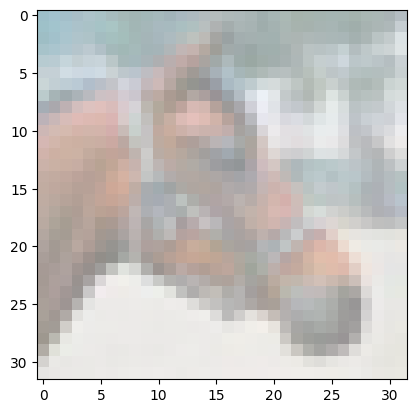

True label: 7
Predicted class: 7
True label name: horse
Predicted label name: horse


In [20]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
image, label = testset[17]
imshow(image)

image = image.unsqueeze(0).to(device)

conv_model = BottleneckModel(in_ch=3, num_classes=10, bottleneck_configs=bottleneck_config).to(device)
conv_model.load_state_dict(torch.load('./saved_models/bt/best_test_model', weights_only=True))
# Set the model to evaluation mode
conv_model.eval()
output = conv_model(image)

predicted_class = output.argmax(dim=1).item()

# Print the result
print(f"True label: {label}")
print(f"Predicted class: {predicted_class}")

class_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
print(f"True label name: {class_labels[label]}")
print(f"Predicted label name: {class_labels[predicted_class]}")


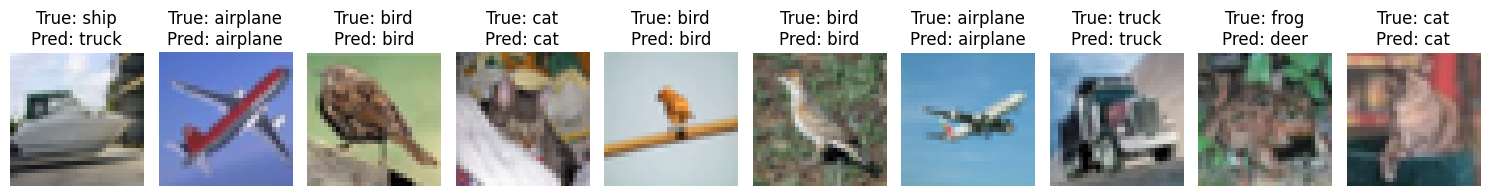

In [17]:
class_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
test_and_display_random_images(conv_model, testset, num_images=10, class_labels=class_labels, device=device)
